# Mooomentums
Mooom is a strategy that heavily relies on momentum. It enriches dataframe with simple momentum and industrial momentum factors. Returns will be substracted by a cross-sectional median.

In [1]:
from functools import reduce
import numpy as np
import pandas as pd
from pandas.tseries.offsets import DateOffset
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.options.mode.chained_assignment = None
np.seterr(divide="ignore", invalid="ignore")
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_parquet("compustat_ibes_raw_alpha.1.parquet")

In [4]:
def conf(clf, X_test, y_test):
    f, ax = plt.subplots(figsize=(4.8, 4.8))
    y_test_pred = clf.predict(X_test)
    conf_mat = confusion_matrix(y_test, y_test_pred)
    conf_ax = sns.heatmap(
        conf_mat, ax=ax, annot=True, fmt="", cmap=plt.cm.Blues, cbar=False
    )
    conf_ax.set_xlabel("Predicted")
    conf_ax.set_ylabel("True")

In [6]:
def computeRSI(data, time_window):
    diff = data.diff(1)  # diff in one field(one day)

    # this preservers dimensions off diff values
    up_chg = 0 * diff
    down_chg = 0 * diff

    # up change is equal to the positive difference, otherwise equal to zero
    up_chg[diff > 0] = diff[diff > 0]

    # down change is equal to negative deifference, otherwise equal to zero
    down_chg[diff < 0] = diff[diff < 0]

    # check pandas documentation for ewm
    # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.ewm.html
    # values are related to exponential decay
    # we set com=time_window-1 so we get decay alpha=1/time_window
    up_chg_avg = up_chg.ewm(com=time_window - 1, min_periods=time_window).mean()
    down_chg_avg = down_chg.ewm(com=time_window - 1, min_periods=time_window).mean()

    rs = abs(up_chg_avg / down_chg_avg)
    rsi = 1 - 1 / (1 + rs)
    return rsi

In [8]:
def mooom(df):
    """
    Mooom is a strategy that heavily relies on momentum.
    It enriches dataframe with simple momentum and industrial momentum factors. 
    Returns will be substracted by a cross-sectional median.
    """
    df_mom = df
    df_mom = df_mom['low high close prccd mcap'.split()]
    df_mom = df_mom.loc[df.prccd > 10]
    times = [3, 4, 5, 10, 20, 40]
    
    df = df_mom
    df["return"] = df_mom.close.groupby("gvkey").transform(lambda x: x.pct_change(1))
    for time in times:
        df[f"RET {time}"] = df.close.groupby("gvkey").transform(lambda x: x.pct_change(time - 1))
        df[f"STD {time}"] = df['return'].groupby("gvkey").transform(lambda x: x.rolling(time).std())
        df[f"EMA {time}"] = df.close.groupby("gvkey").transform(lambda x: x / x.ewm(span=time, adjust=False).mean() -1 )
        df[f"SH {time}"] = df['return'].groupby("gvkey").transform(lambda x: x.rolling(time).mean() / x.rolling(time).std())
        df[f"QT {time}"] = df['close'].groupby("gvkey").transform(lambda x: x.rolling(time).quantile(0.75) / x)
        df[f"SCOSC {time}"] = df['close'].groupby("gvkey").transform(lambda x: (x - x.rolling(time).min()) 
                                                                     / (x.rolling(time).max() - x.rolling(time).min()))
        df[f"RSI {time}"] = df['close'].groupby("gvkey").transform(lambda x: computeRSI(x,time))

    df['high'] = df['high'] / df['close'] - 1
    df['low'] = df['low'] / df['close'] - 1
    
    df_mom = df
    df_mom["return"] = df_mom.close.groupby("gvkey").transform(lambda x: x.pct_change(3))
    df_mom["targ_return"] = df_mom.close.groupby("gvkey").transform(lambda x: x.pct_change(3).shift(-3))

    df_mom["y1"] = np.where(df_mom['targ_return'] > 0.05, 1, 0)
    df_mom["y2"] = np.where(df_mom['targ_return'] < -0.03, -1, 0)
    df_mom["y"] = df_mom["y2"] + df_mom["y1"]
    
    df_mom = df_mom.drop('y2',axis=1)
    df_mom = df_mom.drop('y1',axis=1)
    df_mom = df_mom.drop('targ_return',axis=1)
    df_mom = df_mom.drop('prccd',axis=1)
    df_mom = df_mom.drop('close',axis=1)
    df_mom = df_mom.drop('mcap',axis=1)
    return df_mom.dropna()

In [9]:
df_mom = mooom(df)

In [10]:
df_backup = df_mom.copy()

In [11]:
# df_mom = df_backup.copy()

In [12]:
df_mom.head()

low      high    return     RET 3     STD 3     EMA 3  \
gvkey  date                                                                     
001166 2003-07-31 -0.147281  0.135582  0.188062  0.128982  0.046099  0.064181   
       2003-08-31 -0.219601  0.075620  0.284382  0.261832  0.062572  0.095293   
       2003-09-30 -0.021961  0.341176 -0.026718 -0.122505  0.203771 -0.084112   
       2003-10-31 -0.157965  0.054217  0.028217 -0.096189  0.222001  0.035310   
       2003-11-30 -0.053797  0.069620 -0.044162  0.239216  0.206287  0.045303   

                       SH 3      QT 3   SCOSC 3     RSI 3     RET 4     STD 4  \
gvkey  date                                                                     
001166 2003-07-31  1.296925  0.950791  1.000000  0.729954  0.188062  0.060635   
       2003-08-31  1.409997  0.939504  1.000000  0.853490  0.284382  0.054150   
       2003-09-30  0.029660  1.218039  0.000000  0.371582 -0.026718  0.166483   
       2003-10-31  0.121224  1.053213  0.579365  0.578439  0.028217  0.185870   
       2003-11-30  0.001055  0.972785  1.000000  0.646903 -0.044162  0.181910   

                      EMA 4      SH 4      QT 4   SCOSC 4     RSI 4     RET 5  \
gvkey  date                                                                     
001166 2003-07-31  0.078164  1.378017  0.926187  1.000000  0.607385  0.372049   
       2003-08-31  0.124645  1.463553  0.909256  1.000000  0.736002  0.351594   
       2003-09-30 -0.083972  0.054063  1.178824  0.000000  0.403171 -0.009324   
       2003-10-31  0.042767  0.255416  1.026606  0.579365  0.557685  0.140458   
       2003-11-30  0.059240  0.190066  1.011551  0.806878  0.610485  0.087405   

                      STD 5     EMA 5      SH 5      QT 5   SCOSC 5     RSI 5  \
gvkey  date                                                                     
001166 2003-07-31  0.096967  0.081172  0.485734  0.901583  1.000000  0.538816   
       2003-08-31  0.057815  0.142410  1.632340  0.879008  1.000000  0.650957   
       2003-09-30  0.145475 -0.082488  0.121440  1.139608  0.000000  0.413447   
       2003-10-31  0.161511  0.048849  0.257278  1.000000  0.579365  0.536042   
       2003-11-30  0.161031  0.070258  0.307344  1.000000  0.806878  0.579212   

                     RET 10    STD 10    EMA 10     SH 10     QT 10  SCOSC 10  \
gvkey  date                                                                     
001166 2003-07-31 -0.004795  0.137098  0.018059 -0.087456  0.975396  0.912037   
       2003-08-31  0.271538  0.129652  0.125811  0.156232  0.857381  1.000000   
       2003-09-30  0.003937  0.147187 -0.110342  0.056712  1.111569  0.363636   
       2003-10-31  0.002012  0.155241  0.034482  0.179279  0.991633  0.732323   
       2003-11-30  0.344681  0.147217  0.075641  0.109948  0.939082  0.877104   

                     RSI 10    RET 20    STD 20    EMA 20     SH 20     QT 20  \
gvkey  date                                                                     
001166 2003-07-31  0.458782  0.135156  0.196410 -0.111728 -0.019038  1.456469   
       2003-08-31  0.507955 -0.057045  0.167772  0.009526  0.153388  1.280248   
       2003-09-30  0.426567 -0.250000  0.156177 -0.204561 -0.026740  1.659804   
       2003-10-31  0.480183 -0.313103  0.160864 -0.061863  0.036825  1.416499   
       2003-11-30  0.500559 -0.254717  0.148161 -0.007117 -0.034885  1.184810   

                   SCOSC 20    RSI 20    RET 40    STD 40    EMA 40     SH 40  \
gvkey  date                                                                     
001166 2003-07-31  0.206175  0.455204 -0.436822  0.230274 -0.225815  0.054493   
       2003-08-31  0.310832  0.477724 -0.487442  0.230481 -0.114098  0.056169   
       2003-09-30  0.113030  0.441422 -0.595238  0.230284 -0.305961  0.004251   
       2003-10-31  0.227630  0.466161 -0.588996  0.231817 -0.179272  0.025255   
       2003-11-30  0.272632  0.475759 -0.457045  0.230737 -0.126402  0.014928   

                      QT 40  SCOSC 40    RSI 40 

In [13]:
df_mom.y.value_counts()

 1    40063
 0    35023
-1    34019
Name: y, dtype: int64

## Multi Classification

In [14]:
def threshold(y):
    return y

## Portfolio Return

In [50]:
df_train = df_mom.xs(slice("2002-01-01", "2010-01-01"), level="date", drop_level=False).groupby("date").apply(extreme)
df_test = df_mom.xs(slice("2010-01-01", "2020-01-01"), level="date", drop_level=False)
X_train = df_train.drop(["y"], axis=1)
y_train= threshold(df_train.y)
X_test = df_test.drop(["y"], axis=1)
y_test= threshold(df_test.y)
xgb_clf = XGBClassifier(n_jobs=-1, 
                        class_weight='balanced',
                        max_depth=6,
                        learning_rate=0.3
                       )
xgb_fit = xgb_clf.fit(X_train, y_train)
y_pred= xgb_clf.predict(X_test)
train_score = accuracy_score(y_train, xgb_clf.predict(X_train))
test_score = accuracy_score(y_test, y_pred)
print(f"Accuracy on training set: {train_score}\nAccuracy on test set: {test_score}")
print(classification_report(y_test, y_pred, target_names=["sell", 'hold', "buy"]))

[14:03:12] WARNING: ../src/learner.cc:516: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Accuracy on training set: 0.6879295532646048
Accuracy on test set: 0.3727823938917584
              precision    recall  f1-score   support

        sell       0.30      0.27      0.28     16993
        hold       0.47      0.27      0.34     20206
         buy       0.37      0.56      0.45     20690

    accuracy                           0.37     57889
   macro avg       0.38      0.37      0.36     57889
weighted avg       0.38      0.37      0.36     57889



In [61]:
def frame_to_signals(frame, estimator):
    X = frame.drop(columns="y").to_numpy()
    short_array = -1 * estimator.predict_proba(X)[:, 0]
    long_array = estimator.predict_proba(X)[:, -1]
    short_signal = pd.Series(short_array, frame.index)
    long_signal = pd.Series(long_array, frame.index)
    return short_signal, long_signal

In [62]:
def noise_to_belief(signal, n):
    return signal.groupby("date", group_keys=False).apply(lambda x: x.sort_values(ascending=False).head(n))

In [63]:
def monthly_to_daily(signal, months, weight):
    daily_signals = []
    for index, value in signal.iteritems():
        gvkey = index[0]
        predict_date = pd.to_datetime(index[1])
        start = predict_date + DateOffset(days=1)
        end = predict_date + DateOffset(months=months)
        date_range = pd.date_range(start, end, freq="D", name="date")
        daily_idx = pd.MultiIndex.from_tuples([(gvkey, date) for date in date_range], names=["gvkey", "date"])
        if weight == "equal":
            daily_signal = pd.Series(np.sign(value), daily_idx)
        elif weight == "value":
            daily_signal = pd.Series(value, daily_idx)
        daily_signals.append(daily_signal)
    return pd.concat(daily_signals)

In [64]:
def signals_to_positions(short_signal, long_signal, n=10, months=3, weight="equal"):
    short_belief = noise_to_belief(short_signal, n)
    long_belief = noise_to_belief(long_signal, n)
    short_daily = monthly_to_daily(short_belief, months, weight)
    long_daily = monthly_to_daily(long_belief, months, weight)
    short_position = short_daily.groupby(["gvkey", "date"]).agg("sum")
    long_position = long_daily.groupby(["gvkey", "date"]).agg("sum")
    neutral_position = pd.concat([short_position, long_position]).groupby(["gvkey", "date"]).agg("sum")
    return short_position, long_position, neutral_position

In [65]:
def position_to_margin(data, position, tx=-0.001, method="percent"):
    merged = pd.merge(position.rename("position"), data.close, how="left", left_index=True, right_index=True)
    merged["close"] = merged.close.groupby("gvkey").fillna(method="ffill")
    merged["tx"] = np.where(position.shift(1) != position, tx, 0)
    if method == "log":
        merged["margin"] = merged.close.groupby("gvkey").transform(lambda x: np.log(x.shift(-1) / x)).fillna(0)
        margin = merged.position * merged.margin + merged.tx
        margin = margin.droplevel("gvkey").resample("D").mean().cumsum()
    elif method == "percent":
        merged["margin"] = merged.close.groupby("gvkey").transform(lambda x: x.pct_change(1)).fillna(0)
        margin = (merged.position * merged.margin + merged.tx)
        margin = 1 + (margin.droplevel("gvkey").resample("D").mean().cumsum())
    return margin

In [66]:
def sharpe_ratio(data, position):
    merged = pd.merge(position.rename("position"), data.close, how="left", left_index=True, right_index=True)
    merged["close"] = merged.close.groupby("gvkey").fillna(method="ffill")
    merged["tx"] = np.where(position.shift(1) != position, -0.001, 0)
    merged["margin"] = merged.close.groupby("gvkey").transform(lambda x: x.pct_change(1)).fillna(0)
    margin = merged.position * merged.margin
    margin = margin + merged.tx * abs(margin) * 2
    margin = margin.droplevel("gvkey").resample("D").mean()
    return margin.mean() / margin.std() * np.sqrt(252)

In [67]:
data = pd.read_parquet("daily_price_backtest.parquet")
data = data[data.index.get_level_values("gvkey") != '249103']
short_signal, long_signal = frame_to_signals(df_test, xgb_clf)
short_position, long_position, neutral_position = signals_to_positions(short_signal, long_signal, n=30, months=3, weight="equal")

sharpe 1.5738854881036244


<AxesSubplot:xlabel='date'>

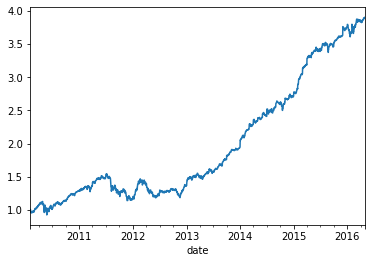

In [68]:
margin = position_to_margin(data, long_position, method="percent")
print('sharpe', sharpe_ratio(data,long_position))
margin.plot()

sharpe 1.119069078802168


<AxesSubplot:xlabel='date'>

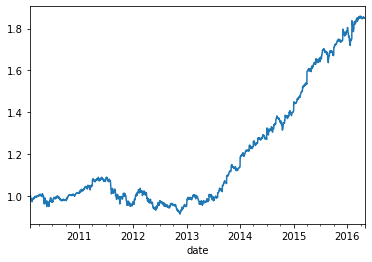

In [69]:
margin = position_to_margin(data, neutral_position, method="percent")
print('sharpe', sharpe_ratio(data, neutral_position))
margin.plot()

sharpe -1.7717305959600913


<AxesSubplot:xlabel='date'>

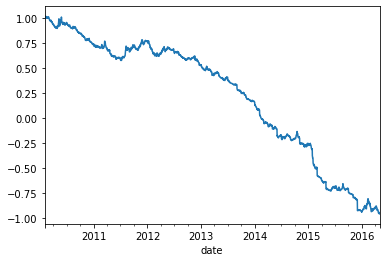

In [70]:
margin = position_to_margin(data, short_position, method="percent")
print('sharpe', sharpe_ratio(data,short_position))
margin.plot()